In [ ]:

import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import torch
import numpy as np
import snntorch as snn
import snntorch.functional as SF
from snntorch import surrogate
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load Data
# Data Preprocessing
data_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
train_data_path = 'archive\\Animal Image Dataset'
full_dataset = ImageFolder(root=train_data_path, transform=data_transform)


In [ ]:
train_data_path = 'archive\\Animal Image Dataset'
full_dataset = ImageFolder(root=train_data_path, transform=data_transform)

# Split Dataset into Training and Testing (80-20 split)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load the model
class SNNModel(nn.Module):
    def __init__(self):
        super(SNNModel, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lif1 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.lif2 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 45 * 45, 128)
        self.lif_fc1 = snn.Leaky(beta=0.9, threshold=1.0, spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(128, len(full_dataset.classes))

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_fc1 = self.lif_fc1.init_leaky()

        # Layer 1
        x = self.conv1(x)
        x = self.pool1(x)
        x, mem1 = self.lif1(x, mem1)

        # Layer 2
        x = self.conv2(x)
        x = self.pool2(x)
        x, mem2 = self.lif2(x, mem2)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully Connected Layers
        x = self.fc1(x)
        x, mem_fc1 = self.lif_fc1(x, mem_fc1)
        x = self.fc2(x)

        return x

# Initialize and load the model
snn_model = SNNModel().to(device)
snn_model.load_state_dict(torch.load('snn_model.pth', map_location=device))
snn_model.eval()

# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Prediction function
def predict(image_path, model, label_map):
    img = Image.open(image_path).convert("RGB")
    img = data_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        class_name = label_map[predicted.item()]
        return class_name


C:\Users\psono\AppData\Local\Temp\ipykernel_2968\299166962.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snn_model.load_state_dict(torch.load('snn_model.pth', map_loc

In [ ]:
# Initialize and load the model
snn_model = SNNModel().to(device)
snn_model.load_state_dict(torch.load('snn_model1.pth', map_location=device))
snn_model.eval()

C:\Users\psono\AppData\Local\Temp\ipykernel_2968\4224974624.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snn_model.load_state_dict(torch.load('snn_model1.pth', map_lo

SNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lif1): Leaky()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lif2): Leaky()
  (fc1): Linear(in_features=129600, out_features=128, bias=True)
  (lif_fc1): Leaky()
  (fc2): Linear(in_features=128, out_features=12, bias=True)
)

In [ ]:
# Prediction function
def predict(image_path, model, label_map):
    img = Image.open(image_path).convert("RGB")
    img = data_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        class_name = label_map[predicted.item()]
        return class_name


In [ ]:
# Define the label map (assuming it’s the same as used in training)
label_map = {v: k for k, v in full_dataset.class_to_idx.items()}

# Folder path containing test images
test_folder = 'test'  # Replace with the path to your test folder


In [ ]:
# Iterate over test images and display each with its predicted label
# fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Adjust grid size as needed
# axs = axs.flatten()


Image '349.jpeg' - Predicted Label: hen
Image 'butterfly.jpeg' - Predicted Label: butterfly
Image 'cats.jpeg' - Predicted Label: cats
Image 'dogs_00014.jpg' - Predicted Label: dogs
Image 'e83cb30c2bf6043ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5ecb5b1_640.jpg' - Predicted Label: spider
Image 'elephant.jpg' - Predicted Label: elephant
Image 'n3019.jpg' - Predicted Label: monkey
Image 'OIP-lS06W6bD81zXI1l_yxfwUAHaGv.jpeg' - Predicted Label: horse
Image 'OIP-_6Rc2FXOSBnWvJHlGQX2EwHaE8.jpeg' - Predicted Label: dogs
Image 'OIP-_XTo_PganejtNU_34Qf-4AHaE8.jpeg' - Predicted Label: cow


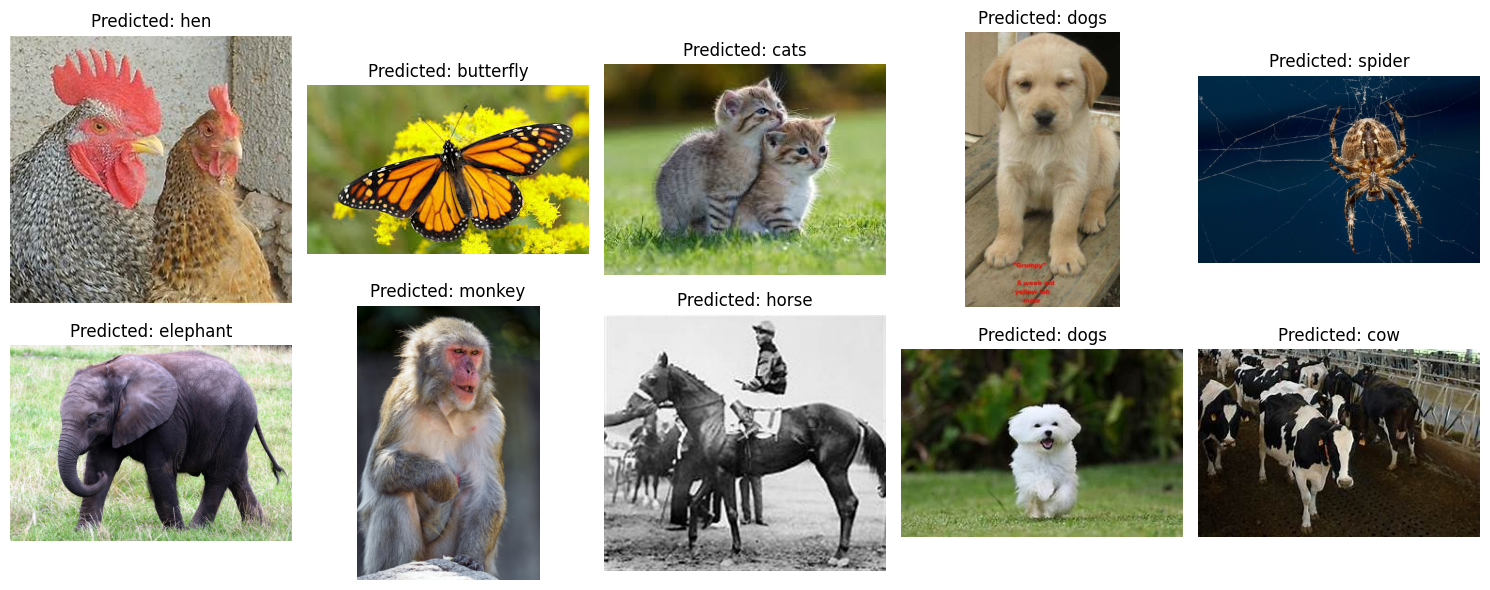

In [ ]:

# Verify that the test folder exists
if not os.path.exists(test_folder):
    print(f"Test folder '{test_folder}' not found.")
else:
    # Plot test images with predictions
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    axs = axs.flatten()

    for idx, image_file in enumerate(os.listdir(test_folder)):
        if idx >= 10:
            break
        
        image_path = os.path.join(test_folder, image_file)
        
        try:
            # Load and predict
            predicted_label = predict(image_path, snn_model, label_map)
            img = Image.open(image_path)

            # Display the image and predicted label
            axs[idx].imshow(img)
            axs[idx].set_title(f"Predicted: {predicted_label}")
            axs[idx].axis('off')
            print(f"Image '{image_file}' - Predicted Label: {predicted_label}")  # Debug output
            
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")
            axs[idx].axis('off')  # Leave the axis empty if there's an error

    plt.tight_layout()
    plt.show()  # Ensure the plot is displayed

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Initialize lists to store true labels and predicted labels
all_labels = []
all_predictions = []
correct = 0
total = 0

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = snn_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Append true labels and predicted labels to the lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate weighted metrics
precision_weighted = precision_score(all_labels, all_predictions, average='weighted')
recall_weighted = recall_score(all_labels, all_predictions, average='weighted')
f1_weighted = f1_score(all_labels, all_predictions, average='weighted')

# Calculate macro metrics
precision_macro = precision_score(all_labels, all_predictions, average='macro')
recall_macro = recall_score(all_labels, all_predictions, average='macro')
f1_macro = f1_score(all_labels, all_predictions, average='macro')

# Calculate micro metrics
precision_micro = precision_score(all_labels, all_predictions, average='micro')
recall_micro = recall_score(all_labels, all_predictions, average='micro')
f1_micro = f1_score(all_labels, all_predictions, average='micro')
num_classes = len(np.unique(all_labels))  # Number of unique classes in the dataset
class_names = [f'Class {i}' for i in range(num_classes)] 
# Generate classification report
class_report = classification_report(all_labels, all_predictions, target_names=class_names)

# Print Testing Accuracy
test_accuracy = 100 * correct / total
print(f'Testing Accuracy: {test_accuracy:.2f}%')

# Print the evaluation metrics
print("\n--- Evaluation Metrics ---")
print(f'Weighted Precision: {precision_weighted:.4f}')
print(f'Weighted Recall: {recall_weighted:.4f}')
print(f'Weighted F1 Score: {f1_weighted:.4f}\n')

print(f'Macro Precision: {precision_macro:.4f}')
print(f'Macro Recall: {recall_macro:.4f}')
print(f'Macro F1 Score: {f1_macro:.4f}\n')

print(f'Micro Precision: {precision_micro:.4f}')
print(f'Micro Recall: {recall_micro:.4f}')
print(f'Micro F1 Score: {f1_micro:.4f}\n')

# Print classification report
print("--- Classification Report ---")
print(class_report)


Testing Accuracy: 84.46%

--- Evaluation Metrics ---
Weighted Precision: 0.8460
Weighted Recall: 0.8446
Weighted F1 Score: 0.8447

Macro Precision: 0.8459
Macro Recall: 0.8457
Macro F1 Score: 0.8452

Micro Precision: 0.8446
Micro Recall: 0.8446
Micro F1 Score: 0.8446

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.84      0.89      0.86       266
     Class 1       0.75      0.84      0.79       282
     Class 2       0.90      0.82      0.86       299
     Class 3       0.84      0.79      0.82       306
     Class 4       0.84      0.85      0.85       279
     Class 5       0.89      0.86      0.87       316
     Class 6       0.87      0.86      0.86       287
     Class 7       0.86      0.88      0.87       310
     Class 8       0.89      0.91      0.90       233
     Class 9       0.83      0.86      0.85       297
    Class 10       0.84      0.79      0.81       276
    Class 11       0.80      0.79      0.80       28

In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2  # OpenCV for PSNR calculation
import matplotlib.pyplot as plt

# Function to calculate SSIM, PSNR, and MSE
def calculate_metrics(true_image, predicted_image):
    # Convert images to grayscale for SSIM
    true_image_gray = cv2.cvtColor(true_image, cv2.COLOR_RGB2GRAY)
    predicted_image_gray = cv2.cvtColor(predicted_image, cv2.COLOR_RGB2GRAY)
    
    # Calculate MSE
    mse_value = np.mean((true_image_gray - predicted_image_gray) ** 2)

    # Calculate SSIM
    ssim_value = ssim(true_image_gray, predicted_image_gray)

    # Calculate PSNR
    if mse_value == 0:
        psnr_value = float('inf')  # If MSE is zero, PSNR is infinite
    else:
        psnr_value = 20 * np.log10(255.0 / np.sqrt(mse_value))

    return ssim_value, psnr_value, mse_value

# List to store metrics
ssim_values = []
psnr_values = []
mse_values = []

ground_truth_folder = train_dataset  # Replace with the path to your ground truth folder

if not os.path.exists(test_folder):
    print(f"Test folder '{test_folder}' not found.")
else:
    for idx, image_file in enumerate(os.listdir(test_folder)):
        if idx >= 10:  # Limit to 10 images
            break
        
        image_path = os.path.join(test_folder, image_file)
        ground_truth_path = os.path.join(ground_truth_folder, image_file)  # Assuming ground truth images have the same names
        
        try:
            # Load ground truth image
            true_image = Image.open(ground_truth_path).convert("RGB")
            true_image = np.array(true_image)

            # Load and predict
            predicted_label = predict(image_path, snn_model, label_map)
            img = Image.open(image_path).convert("RGB")
            predicted_image = np.array(img)

            # Calculate metrics
            ssim_value, psnr_value, mse_value = calculate_metrics(true_image, predicted_image)
            ssim_values.append(ssim_value)
            psnr_values.append(psnr_value)
            mse_values.append(mse_value)

            print(f"Image '{image_file}' - SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f}, MSE: {mse_value:.4f}")

        except Exception as e:
            print(f"Error loading image {image_file}: {e}")

# Plot metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(ssim_values, marker='o')
plt.title('SSIM Values')
plt.xlabel('Image Index')
plt.ylabel('SSIM')

plt.subplot(1, 3, 2)
plt.plot(psnr_values, marker='o')
plt.title('PSNR Values')
plt.xlabel('Image Index')
plt.ylabel('PSNR (dB)')

plt.subplot(1, 3, 3)
plt.plot(mse_values, marker='o')
plt.title('MSE Values')
plt.xlabel('Image Index')
plt.ylabel('MSE')

plt.tight_layout()
plt.show()

TypeError: expected str, bytes or os.PathLike object, not Subset